
## Introduction to Markov Chain Monte Carlo methods

#### Hector A. Corzo-Pola, Graduate Student
#### Department of Geological Sciences, Jackson School of Geosciences, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/hcorzopola/)

#### Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

Here's an introduction to Markov Chains Markov Chain Monte Carlo (MCMC) methods. MCMC methods are useful for estimating probability distributions that are impractical (never enough samples) or impossible (no analytical closed form solution) to compute directly. First, we introduce the concept of a Markov Chain with the Gibbs sampler for the well-known daily weather example, then we explain the importance of MCMC methods for sampling probability distributions. Finally, we show the application of different MCMC methods to Bayesian regression.

*MCMC is a very broad topic of study; therefore, we won't be able to cover all possible MCMC methods and all details in this workflow. We hope this will isnpire folks to learn more about this powerful method.*

### Import Packages

In [1]:
import numpy as np                        # arrays and computations on Python
from numpy import random                  # sampling from different distributions
import matplotlib.pyplot as plt           # for plotting
#import matplotlib.animation as animation
import pymc3 as pm                        # probabilistic programming
import arviz as az                        # evaluation of regression parameters
from ipywidgets import widgets            # widgets for interactive cells
from ipywidgets import interactive        # ''
from ipywidgets import VBox, HBox         # ''
from IPython.display import display       # ''
#from ipywidgets import Layout
#from ipywidgets import Label

### Functions
#### Code for weather models

In [104]:
def weatherModelMC(initialConditions, transitionMatrix, nSteps): # Get marginal probs for a weather model using Markov Chain
    prob = np.array([transitionMatrix[1][0],transitionMatrix[0][0]]) # [Rain2Sunny = 0.1, Sunny2Sunny = 0.9]
    state = initialConditions[0] # Start with a sunny day. 0 = Rain, 1 = Sun
    sunArray = np.zeros(nSteps*100)
    pSun = np.zeros(nSteps*100)
    for i in range(nSteps*100):
        sunArray[i] = state
        pSun[i] = np.sum(sunArray[:i+1])/(i+1)
        state = random.binomial(1,prob[state])
    pRain = 1 - pSun
    
    plt.plot(range(nSteps),pSun[:nSteps],color='y',label='Sunny',linewidth=1,linestyle='--',zorder=1)
    plt.plot(range(nSteps),pRain[:nSteps],color='grey',label='Rain',linewidth=1,linestyle='--',zorder=1)
    plt.scatter(range(nSteps),pSun[:nSteps],color='yellow',s=12,edgecolor='black',zorder=2)
    plt.scatter(range(nSteps),pRain[:nSteps],color='lightgrey',s=12,edgecolor='black',zorder=2)
    plt.plot([0,nSteps],[pSun[-1],pSun[-1]],color='gold',linewidth=1,linestyle='--')
    plt.plot([0,nSteps],[pRain[-1],pRain[-1]],color='dimgrey',linewidth=1,linestyle='--')
    plt.title('Markov Chain with Gibbs Sampler for Sunny and Rainy Weather')
    plt.xlabel('Step'); plt.ylabel('Cumulative Markov Chain Probability'); plt.ylim(0,1)
    plt.xscale('log'); plt.xlim([1,nSteps])
    plt.legend(); 
    #plt.grid(axis='x')
    plt.grid(b=True,axis='x',which='major',color='black',linestyle='-',linewidth=0.6)
    plt.grid(b=True,axis='x',which='minor',color='grey',linestyle='-',linewidth=0.5)
    plt.annotate('P(Sunny)= ' + str(round(pSun[-1],2)),[1.1,pSun[-1]+0.01])
    plt.annotate('P(Rain)= ' + str(round(pRain[-1],2)),[1.1,pRain[-1]+0.01])
    
    return pSun, pRain

def weatherModel(initialConditions, transitionMatrix, nSteps): # Get marginal probs for a weather model
    state = initialConditions
    pSun = np.zeros(nSteps)
    pRain = np.zeros(nSteps)
    for i in range(nSteps):
        pSun[i] = state[0]
        pRain[i] = state[1]
        state = np.matmul(state,transitionMatrix)
    
    plt.plot(range(nSteps),pSun,color='blue',linewidth=10,label='P(Sun)')
    plt.plot(range(nSteps),pRain,color='grey',linewidth=10,label='P(Rain)')
    plt.title('Probabilities with Direct Computation')
    plt.xlabel('Step'); plt.ylabel('Probability'); plt.ylim(0,1)
    plt.legend()

    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1., wspace=0.1, hspace=0.2)
    plt.show()
    
    print('The steady state vector for the weather shows that, P(Sun) = '+str(round(pSun[-1],3)),' P(Rain) = '+str(round(pRain[-1],3)))
    
    return pSun, pRain

#### Code for interactive weather model

In [96]:
iWeather = widgets.ToggleButtons(options=['Sun','Rain'], description='Day 1:')
pS2Sslider = widgets.FloatSlider(min=0, max=1, value=0.9, step=0.05, description="P(Sun,Sun)",continuous_update=False)
pR2Sslider = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, description="P(Sun,Rain)",continuous_update=False)
nStepsSlider = widgets.IntSlider(min=100, max=3000, value=1500, step=100, description="# of Steps",continuous_update=False)
weatherLBox = VBox([iWeather,nStepsSlider])
weatherRBox = VBox([pS2Sslider,pR2Sslider])
weatherUI = HBox([weatherLBox,weatherRBox])

def test(iConditions, pS2S, pR2S, nSteps): # Get marginal probs for a weather model
    np.random.seed(5112021) # Set random state
    transitionMatrix = np.array([[pS2S,1-pS2S],[pR2S,1-pR2S]]) # [[Sunny2Sunny, Sunny2Rain],[Rain2Sunny, Rain2Rain]]
    
    aSteps = 50
    weatherDict = {'Sun':[1,0], 'Rain':[0,1]}
    state = weatherDict[iConditions]
    pSun = np.zeros(aSteps)
    pRain = np.zeros(aSteps)
    for i in range(aSteps):
        pSun[i] = state[0]
        pRain[i] = state[1]
        state = np.matmul(state,transitionMatrix)
    
    print('The steady state vector for the weather shows that, P(Sun) = '+str(round(pSun[-1],3)),' P(Rain) = '+str(round(pRain[-1],3)))
    
    plt.subplot(121)
    plt.plot(range(aSteps),pSun,color='m',label='P(Sun)')
    plt.plot(range(aSteps),pRain,color='c',label='P(Rain)')
    plt.title('Probabilities with Direct Computation')
    plt.xlabel('Step'); plt.ylabel('Probability'); plt.ylim(0,1)
    plt.legend()
    
    weatherDict = {'Sun':1, 'Rain':0}
    prob = np.array([transitionMatrix[1][0],transitionMatrix[0][0]]) # [Rain2Sunny = 0.1, Sunny2Sunny = 0.9]
    state = weatherDict[iConditions] # Start with a sunny day. 0 = Rain, 1 = Sun
    sunArray = np.zeros(nSteps)
    pSun = np.zeros(nSteps)
    for i in range(nSteps):
        sunArray[i] = state
        pSun[i] = np.sum(sunArray[:i+1])/(i+1)
        state = random.binomial(1,prob[state])
    pRain = 1 - pSun

    print('At last step, P(Sun) = '+str(round(pSun[-1],3)),' P(Rain) = '+str(round(pRain[-1],3)))
    
    plt.subplot(122)
    plt.plot(range(nSteps),pSun,color='m',label='P(Sun)')
    plt.plot(range(nSteps),pRain,color='c',label='P(Rain)')
    plt.title('Probabilities with Monte Carlo')
    plt.xlabel('Step'); plt.ylabel('Probability'); plt.ylim(0,1)
    plt.legend()

    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1., wspace=0.1, hspace=0.2)


#### Code for Bayesian regression models

In [31]:
def buildModel(nDraws,nTune,nChains,sampler):
    with pm.Model() as linear_model:
        # Prior distribution for each parameter. Assume Gaussian distribution with large variance
        mPrior = pm.Normal('m', mu = 0, sd = 5) # Model's slope
        bPrior = pm.Normal('b', mu = 0, sd = 5) # Model's intercept
        noisePrior = pm.HalfNormal('sigma', sd = 5) # Homoscedastic error in Std. Deviation

        # Likelihood
        mMean = mPrior * x + bPrior              # Estimate of model's mean
        yObs = pm.Normal('Y_obs', mu = mMean, sd = noisePrior, observed = y) # Observed values

        # Specify the sampler
        if sampler == 'NUTS':
            step = pm.NUTS(target_accept = 0.95) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC
        elif sampler == 'Metropolis':
            step = pm.Metropolis() # use the Metropolis-Hastings Random Walk

        # Posterior distribution
        trace = pm.sample(draws = nDraws, tune = nTune, step = step, random_seed = 12112021, chains = nChains, cores = 2, return_inferencedata = True)
        
    pm.plot_trace(trace)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.1, hspace=0.2)
    plt.show()
    
    return trace

#### Code for interactive Bayesian regression model

In [32]:
mMeanSlider = widgets.FloatSlider(min=-2, max=2, value=0, step=0.1, description="'m' Mean",continuous_update=False)
mSDSlider = widgets.FloatSlider(min=0.1, max=10, value=5, step=0.1, description="'m' SD",continuous_update=False)
bMeanSlider = widgets.FloatSlider(min=-4, max=4, value=0, step=0.2, description="'b' Mean",continuous_update=False)
bSDSlider = widgets.FloatSlider(min=0.1, max=10, value=5, step=0.1, description="'b' SD",continuous_update=False)
modelSDSlider = widgets.FloatSlider(min=0.1, max=10, value=5, step=0.1, description="Model SD",continuous_update=False)
nDrawsSlider = widgets.IntSlider(min=100, max=6000, value=1000, step=100, description="# of Draws",continuous_update=False)
nTuneSlider = widgets.IntSlider(min=100, max=3000, value=1000, step=100, description="# of Tuning Samples",continuous_update=False)
nChainsSlider = widgets.IntSlider(min=1, max=8, value=2, step=1, description="# of Chains",continuous_update=False)
distributionButtons = widgets.ToggleButtons(options=['Normal','Uniform'], description='Distributions:')
samplerButtons = widgets.ToggleButtons(options=['Metropolis','NUTS'], description='Sampler:')
bayesUIl = VBox([distributionButtons,samplerButtons])
bayesUIm = VBox([mMeanSlider,mSDSlider,bMeanSlider,bSDSlider,modelSDSlider])
bayesUIr = VBox([nDrawsSlider,nTuneSlider,nChainsSlider])
bayesUI = HBox([bayesUIl,bayesUIm,bayesUIr])
UIpar = {'nDraws':nDrawsSlider,'nTune':nTuneSlider,'nChains':nChainsSlider,
         'priorDistribution':distributionButtons,'sampler':samplerButtons,
        'mMean':mMeanSlider,'mSD':mSDSlider,'bMean':bMeanSlider,'bSD':bSDSlider,'modelSD':modelSDSlider}

def buildiModel(mMean,mSD,bMean,bSD,modelSD,nDraws,nTune,nChains,priorDistribution='Normal',sampler='NUTS'):
    global trace
    with pm.Model() as linear_model:
        # Prior distribution for each parameter. Assume Gaussian distribution with large variance
        if priorDistribution == 'Normal':
            mPrior = pm.Normal('m', mu = mMean, sd = mSD) # Model's slope
            bPrior = pm.Normal('b', mu = bMean, sd = bSD) # Model's intercept
        elif priorDistribution == 'Uniform':
            mPrior = pm.Uniform('m', lower = -mSD, upper = mSD) # Model's slope
            bPrior = pm.Uniform('b', lower = -bSD, upper = bSD) # Model's intercept
        noisePrior = pm.HalfNormal('sigma', sd = modelSD) # Homoscedastic error in Std. Deviation

        # Likelihood
        mMean = mPrior * x + bPrior              # Estimate of model's mean
        yObs = pm.Normal('Y_obs', mu = mMean, sd = noisePrior, observed = y) # Observed values

        # Specify the sampler
        if sampler == 'NUTS':
            step = pm.NUTS(target_accept = 0.95) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC
        elif sampler == 'Metropolis':
            step = pm.Metropolis() # use the Metropolis-Hastings Random Walk

        # Posterior distribution
        trace = pm.sample(draws = nDraws, tune = nTune, step = step, random_seed = 12112021, chains = nChains, cores = 2, return_inferencedata = True)

    pm.plot_trace(trace)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.1, hspace=0.2)
    plt.show()
    
    return trace

### Markov Chain Monte Carlo

### 1. Understanding Markov Chains: The Basic Weather Model Example

A *Markov Chain* is a stochastic model which assumes that we can predict the next state ($X_{[i+1]}$) based exclusively on the previous state ($X_{[i]}$). In other words, we don't need to know the full history of the process to predict the next state, but rather the current **state vector** $X_{[i]}$ and the **transition matrix** $P$ that describes the process.

To exemplify this, we will use the ["popular"](https://en.wikipedia.org/wiki/Examples_of_Markov_chains#A_simple_weather_model) example of a simple weather model represented by the following Markov Chain.

<p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Markov_Chain_weather_model_matrix_as_a_graph.png" width="220" height="240" />
</p>


The above figure represents a Markov Chain in which:
1. A sunny day has a $90\%$ chance of being followed by another sunny day and a $10\%$ chance of being followed by a rainy day.
2. A rainy day has a $50\%$ chance of being followed by a sunny day and a $50\%$ chance of being followed by a rainy day.

Another way to represent this is with the **transition matrix**:

\begin{equation}
P   = \begin{bmatrix}
        P(Sunny | Sunny ) & P(Sunny | Rain) \\
        P(Rain | Sunny ) & P(Rain| Rain)
    \end{bmatrix}
    = \begin{bmatrix}
        0.9 & 0.5 \\
        0.1 & 0.5
    \end{bmatrix} \,.
\end{equation}

We can use Markov Chains to estimate the marginal probabilities of a day being sunny ($P(Sunny)$) or rainy ($P(Rain)$).

To do this we will first select an initial condition (let's say, a sunny day) and then take a random guess of the weather for the following day(s) using the conditional probabilities of our current state. Once we have a long enough chain, we can estimate the marginal probability using the relative frequency. Let's simulate the weather for 15 days! Five times!

In [33]:
def predictNdays(initialConditions,transitionMatrix,nDays):
    prob = np.array([transitionMatrix[1][0],transitionMatrix[0][0]]) # [Rain2Sunny = 0.1, Sunny2Sunny = 0.9]
    state = initialConditions[0] # Start with a sunny day. 0 = Rain, 1 = Sun
    stateList = ['Rain','Sun'] # Relate each numerical value with a label
    statePredictList = list() # List for storing the predicted labels
    sunArray = np.zeros(nDays)
    for i in range(nDays):
        sunArray[i] = state
        statePredictList.append(stateList[state]) # Store the predicted label
        state = random.binomial(1,prob[state]) # Get the next state
    statePredictList.append(';')
    print(*statePredictList)
    
initialConditions = np.array([1,0]) # [1,0] = Sunny, [0,1] = Rain
transitionMatrix = np.array([[0.9,0.1],[0.5,0.5]]) # [[Sunny2Sunny, Sunny2Rain],[Rain2Sunny, Rain2Rain]]
nDays = 15

for i in range(5):
    print('Run {0}:'.format(i+1))
    predictNdays(initialConditions, transitionMatrix, nDays)

Run 1:
Sun Sun Sun Rain Rain Rain Rain Rain Sun Sun Sun Sun Rain Rain Sun ;
Run 2:
Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Rain Sun ;
Run 3:
Sun Sun Rain Sun Sun Rain Rain Sun Sun Sun Sun Sun Sun Sun Sun ;
Run 4:
Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Sun Rain ;
Run 5:
Sun Sun Rain Sun Sun Rain Rain Sun Sun Sun Sun Sun Sun Sun Sun ;


We have just generated five Markov Chains that start with a sunny day. Unfortunately, these chains are too short to actually help us estimate the marginal probabilities.

To get a more appropriate estimate of the marginal probabilities, we have to guess the weather for a larger amount of days (build larger chains). This time, instead of reporting the state of each guess, we will display our estimation of the marginal probabilities after a given number of guesses ($n = 3000$) have been made.

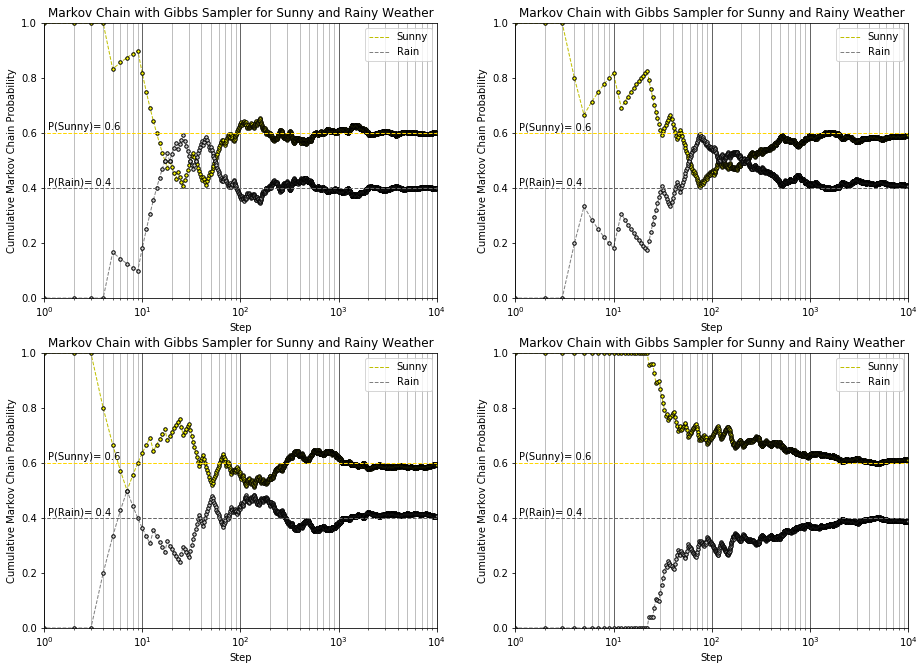

In [106]:
initialConditions = np.array([1,0]) # [1,0] = Sunny, [0,1] = Rain
transitionMatrix = np.array([[0.8,0.2],[0.3,0.7]]) # [[Sunny2Sunny, Sunny2Rain],[Rain2Sunny, Rain2Rain]]

nSteps = 10000
np.random.seed(5112021) # Set random state

plt.subplot(221)
pSun, pRain = weatherModelMC(initialConditions, transitionMatrix, nSteps)

plt.subplot(222)
pSun, pRain = weatherModelMC(initialConditions, transitionMatrix, nSteps)

plt.subplot(223)
pSun, pRain = weatherModelMC(initialConditions, transitionMatrix, nSteps)

plt.subplot(224)
pSun, pRain = weatherModelMC(initialConditions, transitionMatrix, nSteps)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

From the figure above, we can see that the marginal probabilities seem to become stable over time. Can we assess the accuracy of our estimation?

#### Direct computation of the "steady-state" vector
The seemingly stable values we have found are known as the **steady-state** vector ($q$) of the Markov Chain and are defined as:
\begin{equation}
    q = \lim_{n \to \infty} X_{[n]} \,,
\end{equation}
\begin{equation}
    P q = q \,,
\end{equation}
where $X_{[n]}$ is the state vector and $P$ is the transition matrix.

Below, you can see how we can reach the same **steady-state** by advancing the state vector. We will do this by multiplying the current state vector $X_{[n]}$ by the transition matrix $P$ for $n=100$ steps.

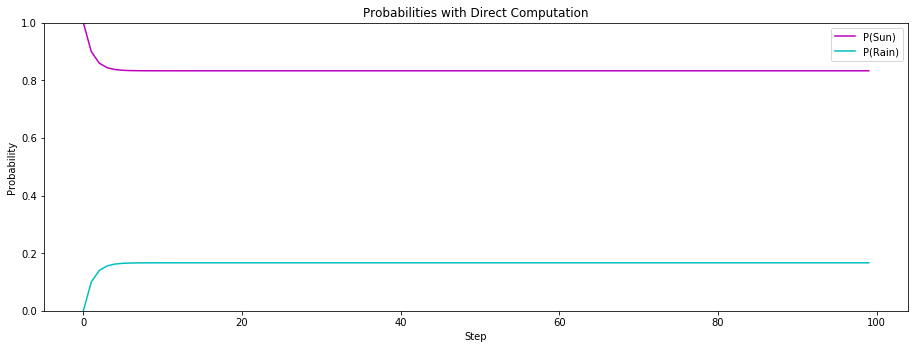

The steady state vector for the weather shows that, P(Sun) = 0.833  P(Rain) = 0.167


In [8]:
nSteps = 100
pSun, pRain = weatherModel(initialConditions, transitionMatrix, nSteps)

We can also compute the **steady-state** for the Markov Chain in this example, as follows:

\begin{align}
    P q &= q \,, \\
    P q &= I q \,, \\
    (P - I) q &= 0 \,.
\end{align}

\begin{equation}
    \left(
    \begin{bmatrix}
        0.9 & 0.5 \\
        0.1 & 0.5
    \end{bmatrix}
    -
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix} \right) q = 0 \,,
\end{equation}

\begin{equation}
    \begin{bmatrix}
        -0.1 & 0.5 \\
        0.1 & -0.5
    \end{bmatrix} q = 0 \,,
\end{equation}

\begin{equation}
    \begin{bmatrix}
        -0.1 & 0.5 \\
        0.1 & -0.5
    \end{bmatrix}
    \begin{bmatrix}
        q_{1} \\ q_{2}
    \end{bmatrix}
    =
    \begin{bmatrix}
        0 \\ 0
    \end{bmatrix}\,,
\end{equation}

\begin{equation}
    - 0.1 q_{1} + 0.5 q_{2} = 0 \,,
\end{equation}

\begin{equation}
    q_{1} = 5 q_{2} \,.
\end{equation}

If you are familiar with linear algebra, you will notice this is similar to calculating the eigenvector for $\lambda = 1$.

From the closure condition, we know that $q_{1} + q_{2} = 1$. Solving for both, we get:

\begin{equation}
    \begin{bmatrix}
        q_{1} \\ q_{2}
    \end{bmatrix}
    =
    \begin{bmatrix}
        0.833 \\ 0.167
    \end{bmatrix} \,.
\end{equation}

*Note: Not every Markov Chain will have a steady-state vector.[The Fundamental Theorem of Markov Chains](http://www.cs.tufts.edu/comp/250P/classpages/Markov.html) states that a Markov Chain must be irreducible and aperiodic to have a unique steady-state vector. Irreducible means that it is possible for every initial state to reach every other state. Aperiodic means it is impossible to get trapped in a cyclical pattern of states.*

By comparing the marginal probabilities yielded by direct computation and by the Monte Carlo simulation, we conclude that we can make a fair estimation of the marginal probabilities using MCMC methods. In particular, we have just used a MCMC sampler known as **Gibbs sampler**.

Here's an interactive that summarizes the previous example. You can change the *initial state* (Sun or Rain), the *transition probabilities* ($P(Sun,Sun)$ and $P(Sun,Rain)$) and the *number of steps* for the Monte Carlo simulation and see how they will modify the steady-state vector and its prediction (e.g. the *initial state* won't change the steady-state vector).

In [9]:
weatherPlot = widgets.interactive_output(test, {'iConditions':iWeather, 'pS2S':pS2Sslider, 'pR2S':pR2Sslider, 'nSteps':nStepsSlider})
display(weatherUI, weatherPlot)

Output()

#### Monte Carlo vs Direct Computation

You might be wondering, *why would I use MCMC if I can directly compute the steady-state vector?* We use MCMC for problems in which the transition matrix is very large. *Think how long it could take to compute 100 steps for a Markov Chain with $1000$ states ($1000 \times 1000$ transition matrix $P$)!*

MCMC methods are the preferred option for sampling from distributions of random processes with high dimensional spaces or continuous features and for optimization in some nonrandom processes for which evaluating all the possible configurations is impossible (e.g. pagerank, traveling salesman problem). MCMC is useful for sampling the posterior distribution in Bayesian inference due to the limitations of computing the evidence term when working with continuous features. *In fact, MCMC samplers and their application to Bayesian Regression is our next topic.*

In general, when working with MCMC methods, we would try to:
1. Define a Markov Chain over the search space: Design a Markov Chain such that the states describe possible solutions and the transition probabilities lead to a steady-state distribution $q$ that has higher probabilities on "good solutions" to the problem.
2. Run Monte Carlo simulations: Given an initial state, simulate new states for the Markov Chain according to the transition probabilites until we get a representative sample of the "target distribution".
3. "Hope" for the best.


*Remember references*
https://math.libretexts.org/Bookshelves/Linear_Algebra/Understanding_Linear_Algebra_(Austin)/04%3A_Eigenvalues_and_eigenvectors/4.05%3A_Markov_chains_and_Google's_PageRank_algorithm
"Probability and Statistics with Applications to Computing"-by Alex Tsun

### 2. Bayesian Regression: Estimating line parameters using MCMC methods

*Now we will cover some MCMC methods and the impact of different parameters related to them.*

#### Quick review of Bayesian Regression
For Bayesian regression, instead of using a single linear combination of the predictor features to estimate the response feature, we assume that the response features comes from the distribution:
\begin{equation}
    y \sim N(\beta^{T} X, \sigma^{2} I) \,,
\end{equation}
where $\beta^{T}$ is a vector containing the regression model parameters and $\sigma^{2} I$ is the variance (multiplied by the identity matrix to keep dimensions consistent).

The model parameters themselves come from the distribution:
\begin{equation}
    P(\beta | y, X) = \frac{P(y,X| \beta) P(\beta)}{P(y,X)} \,,
\end{equation}
derived from the Bayes theorem (hence the name *Bayesian Regression*). The evidence term ($P(y,X)$) is difficult to compute for continuous features, for which we use MCMC methods.

In the following examples, we will use Bayesian Regression to estimate the model parameters for synthetic data. For this, we will first generate a set of synthetic data using a linear model and then we will add noise to it. Our objective will be to estimate the parameters of the line used to generate the data.

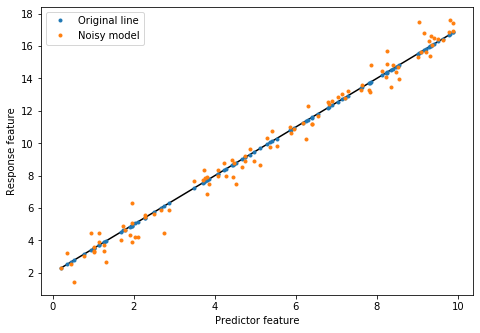

In [15]:
np.random.seed(17041995) # Set random state

# Original line
#x = np.linspace(0,10,100) # "regular sampling"
x = np.sort(np.random.uniform(0, 10, 100)) # "random sampling"
original_m = 1.5
original_b = 2
original_y = original_m * x + original_b
plt.plot(x,original_y,'k')
plt.plot(x,original_y,'.',label='Original line')

# Adding gaussian noise
noise_stdev = 0.75
y = original_y + random.normal(loc = 0.0, scale = noise_stdev, size = len(x)) # add random noise
plt.plot(x,y,'.',label='Noisy model')

plt.xlabel('Predictor feature'); plt.ylabel('Response feature')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.1, hspace=0.2)
plt.show()

Now that we have our data, it's time to built some models to try to estimate the values of the original line parameters.

#### Metropolis-Hastings

This algorithm was invented by Nicholas Metropolis (1953, *Equation of State Calculations by Fast Computing Machines*), but generalized by Wilfred Hastings (1970, *Monte Carlo Sampling Methods Using Markov Chains and Their Applications*). It allows us to draw samples from a probability function if we have a function $f(x)$ proportional to it and works as follows:
1. Initialization: Choose an arbitrary starting point $x_{0}$ and a an arbitrary probability density function to sample the next points ($g(x'|x)$).
2. For $i=1$,...,$n_{Draws}$
  1. Draw a candidate for the next sample, $x'$, from $g(x'|x_{i})$. Often, a normal distribution.
  2. Calculate the acceptance ratio $\alpha = f(x')/f(x_{i})$.
  3. Accept or reject:
      1. Generate a random number from an uniform distribution $u \in [0,1]$.
      2. If $u \leq \alpha$, accept the candidate and set $x_{i+1} = x'$
      3. If $u > \alpha$, reject the candidate and set $x_{i+1} = x_{i}$
      
Whenever we attempt to move to a region of higher probability, we will accept the move. On the other hand, when we attempt to move to a region of lower probability, we will sometimes reject the move, with the rejection probability being proportional to the drop in probability between the current state and the candidate. The final result will be that we will spend more time at regions of high probability.

Let us try using the Metropolis-Hastings algorithm for the Bayesian regression model.

In [16]:
metropolisTrace = buildModel(nDraws = 6000, nTune = 1000, nChains = 2, sampler='Metropolis')

ValueError: Unused step method arguments: {'return_inferencedata'}

Below, you have a summary of the parameter estimation.

In [17]:
az.summary(metropolisTrace, var_names=["m", "b", "sigma"])

NameError: name 'metropolisTrace' is not defined

#### NUTS

Hamiltonian Monte Carlo (HMC) reduces the correlation between successive sampled states by proposing moves to distant states. The reduced correlation between samples allow HMC methods to reach the target distribution in fewer samples; however, the sensitivity of HMC to a hand-picked parameter called $L$ (the number simulated steps of the ficticious Hamiltonian system from which HMC gets its name) can produce some problematic oscillations in the results.

No U-Turn Sampler (NUTS) is an extension of HMC that automatically tunes in the integration time $L$ and makes things easier for the user. 

Let us try using the NUTS algorithm for the Bayesian regression model.

In [18]:
NUTStrace = buildModel(nDraws = 500, nTune = 500, nChains = 2, sampler='NUTS')

ValueError: Unused step method arguments: {'return_inferencedata'}

We can see that the distributions obtained by NUTS are *smoother even with fewer samples* than the ones obtained using the Metropolis-Hastings algorithm

Below, you have a summary of the parameter estimation.

In [ ]:
az.summary(NUTStrace, var_names=["m", "b", "sigma"])

### Closing

By this point, you should be familiar with Markov Chains, and MCMC methods and their application to Bayesian regression. Remember that there are more MCMC methods, with different benefits and limitations. Pick wisely.

Finally, I want to finish this workflow by giving you an interactive version of Bayesian regression in which you can play with some of the parameters. Depending on the parameters you choose, the MCMC run plots might take longer to reload.

In [ ]:
bayesPlots = widgets.interactive_output(buildiModel, UIpar)
display(bayesUI, bayesPlots)

Please run the following cell afterwards to get a summary of the parameter estimation.

In [ ]:
az.summary(trace, var_names=["m", "b", "sigma"])


I hope this was helpful,

*Hector A. Corzo-Pola*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
